In [1]:
# Import Libraries
import numpy as np

from project_utils.bb_model         import BB_Model
from project_utils.feature_stats    import Feature_Statistics_R
from project_utils.feature_stats    import Regression_Container
from project_utils.acq_data_capture import Acq_Data_nD
from project_utils.surroagte_gp     import Surrogate_GP



In [2]:
Num_Points    = 0
Title         = 'Boston'
FUR_Weight    = 0.1
N_consistancy = 25
consist_bound = 0.3

In [3]:
if isinstance(FUR_Weight, float):
    FUR_Weight = [FUR_Weight, 1.0 - FUR_Weight]
    
print(FUR_Weight)

[0.1, 0.9]


In [4]:
Title = Title + ' W:'+ str(FUR_Weight)

In [5]:
# Load Forrester model

Reg_Data = BB_Model(dataset = 'Boston', Feature_Counts=[16,12])

#Reg_Data.df().head()

In [6]:
Reg_Data.MPL()

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.4818931074580599


MLPRegressor(random_state=RandomState(MT19937) at 0x246E6639840)

In [7]:
Reg_Data.Random_Forest()

0.8669258160996606


RandomForestRegressor(random_state=RandomState(MT19937) at 0x246E6639840)

In [8]:
Reg_Data.GP()

-5.826971863436738


GaussianProcessRegressor()

In [9]:
Reg_Data.L_Regression()

0.7220552724640883


LinearRegression()

In [10]:
print(Reg_Data.get_features())

['crime_rate', 'zoned_lots', 'industry', 'by_river', 'NOX', 'avg_rooms', 'pre_1940', 'emp_distance', 'rad_access', 'tax_rate', 'pupil_tea_rat', 'low_status']


In [11]:
#Default settings
from unravel_2.ur_model import UR_Model

X_train, X_test, y_train, y_test = Reg_Data.get_TT_data()

#Initializing the explainer object
URM_Exp = UR_Model(bbox_model           = Reg_Data.get_Random_Forest(),
                   train_data           = X_train,
                   feature_names        = Reg_Data.get_features(),
                   categorical_features = Reg_Data.get_catagorical(),
                   mode                 = Reg_Data.get_mode(),
                   sampling_optimize    = "opt")

#sur_GP = Surrogate_GP()


In [12]:
#I2nd explainer object
URM_Exp_2 = UR_Model(bbox_model           = Reg_Data.get_L_Regression(),
                     train_data           = X_train,
                     feature_names        = Reg_Data.get_features(),
                     categorical_features = Reg_Data.get_catagorical(),
                     mode                 = Reg_Data.get_mode(),
                     sampling_optimize    = "opt")



In [13]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
print('Mean 0:', mean)
print('Std 0: ', std)


Mean 0: [1.43010510e+00 1.22382271e+01 1.05409418e+01 8.58725762e-02
 5.40968421e-01 6.32617175e+00 6.54526316e+01 4.02759668e+00
 7.86426593e+00 3.79944598e+02 1.82900277e+01 1.14508864e+01]
Std 0:  [2.50456772e+00 2.40333052e+01 6.87830100e+00 2.80175796e-01
 1.13620698e-01 6.43824900e-01 2.84481713e+01 2.09349568e+00
 7.50481822e+00 1.50522993e+02 2.17184458e+00 6.13947572e+00]


In [14]:
# Generate explantion data for Random Forest

Reg_Stats   = Feature_Statistics_R(feature_names = Reg_Data.get_features(),
                                   mode          = Reg_Data.get_mode(),
                                   X_train_std   = Reg_Data.get_X_train_std(),
                                   N_consistancy = N_consistancy)

Reg_Stats_2 = Feature_Statistics_R(feature_names = Reg_Data.get_features(),
                                   mode          = Reg_Data.get_mode(),
                                   X_train_std   = Reg_Data.get_X_train_std())


if Num_Points > X_test.shape[0]: Num_Points = X_test.shape[0]

elif Num_Points == 0:            Num_Points = X_test.shape[0]

for test_instance in range(Num_Points):

    print('INSTANCE: ', test_instance)
       
    data_row  = np.array([X_test[test_instance]])
    
#    data_row  = np.array([0.4])

#    print('data row ',data_row)
    
    URM_Exp.explain(X_init      = data_row.reshape(1, -1),
                    Dimension   = 'Multi D',
                    kernel_type = "Matern",
                    max_iter    = 20,
                    alpha       = "FUR_W",
                    #jitter=5,
                    interval    = 1,
                    weight      = FUR_Weight,
                    normalize   = False)
       
    f_predict = Reg_Data.get_Random_Forest().predict(data_row.reshape(1, -1))

    e_predict = URM_Exp.exp_predict(data_row.reshape(1, -1))
    e_predict = np.array(e_predict).ravel()
    
    acq_data = URM_Exp.get_acq_data()
    
#    X, y = URM_Exp.get_surrogate_data()

#    e_predict = sur_GP.predict(X, y)
#    e_predict = sur_GP.predict(URM_Exp.get_surrogate_data())

    print(f_predict, e_predict, acq_data.get_fe_x0())
    
    scores = URM_Exp.permutation_importance()
    
    consistancy = URM_Exp.Y_Consistancy(N_points = N_consistancy, std_bound = consist_bound)
    
    URM_Exp.del_1_rel()
    
    del_1_var = URM_Exp.get_del_1_variance()
    
    Reg_Stats.Add_Sample(sample_scores = scores,
                         outcome       = y_test[test_instance],
                         X_row         = data_row.reshape(1, -1),
                         f_prediction  = f_predict,
                         e_prediction  = e_predict.ravel(),
                         feopt         = acq_data.get_fe_x0(),
                         consistancy   = consistancy,
                         del_1_var     = del_1_var)
    
    
    ############################################################################################
    
    URM_Exp_2.explain(X_init      = data_row.reshape(1, -1),
                      Dimension   = 'Multi D',
                      kernel_type = "Matern",
                      max_iter    = 20,
                      alpha       = "FUR_W",
                      #jitter=5,
                      interval    = 1,
                      weight      = FUR_Weight,
                      normalize   = False)
       
    f_predict = Reg_Data.get_L_Regression().predict(data_row.reshape(1, -1))

    e_predict = URM_Exp_2.exp_predict(data_row.reshape(1, -1))
    e_predict = np.array(e_predict).ravel()
    
    scores = URM_Exp_2.permutation_importance()
    
    Reg_Stats_2.Add_Sample(sample_scores = scores,
                           outcome       = y_test[test_instance],
                           X_row         = data_row.reshape(1, -1),
                           f_prediction  = f_predict,
                           e_prediction  = e_predict.ravel(),
                           feopt         = None)
    


INSTANCE:  0
Acq_Data_nD
[18.93] [1.89300000e+01 1.00000004e-05] [18.93]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  1
Acq_Data_nD
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations

[15.216] [1.52160000e+01 1.00000004e-05] [15.21599998]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  2
Acq_Data_nD
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[22.484] [2.24840000e+01 1.00000004e-05] [22.48400001]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  3
Acq_Data_nD
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
[14.847] [1.48470000e+01 1.00000004e-05] [14.84699999]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  4
Acq_Data_nD
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[17.9] [1.78999999e+01 9.99999486e-06] [17.89999992]
Acq_Data_nD
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In [15]:
import matplotlib.pyplot as plt


In [16]:
print(f_predict)
print(e_predict)


[7.28866243]
[7.28866243e+00 9.99666919e-06]


In [17]:
Reg_Stats.Feature_Counts(max_features=20, scaled=True, threshold=0.05)


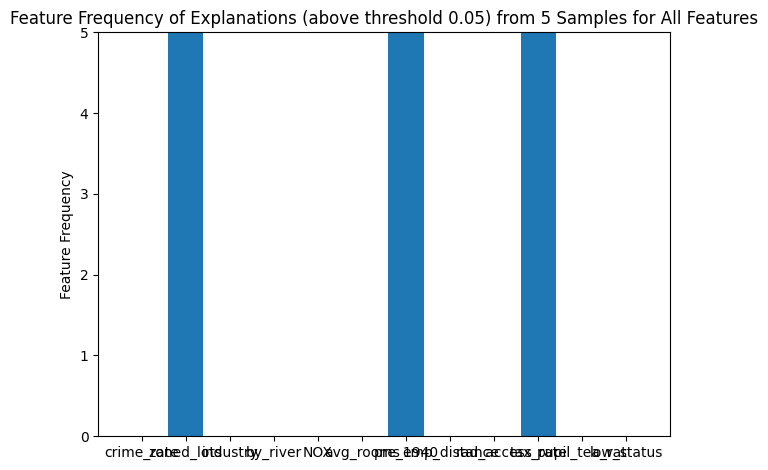

In [18]:
Reg_Stats.Frequency_Plot()


Average, SD, and Max Differences:
y - BB(x):           3.3110000000000044  :  1.470429597090594  :  5.800000000000008
y - exp(x):          3.3110000123777636  :  1.4704296297230874  :  5.800000080819554
BB(x) - exp(x):      2.2356926265842957e-08  :  2.9717279683792447e-08  :  8.081954661065538e-08
Average exp(x) Uncertainty:  9.999999303478559e-06
R Score:   0.9999999999999998
Fidelity:  0.16151219572574457


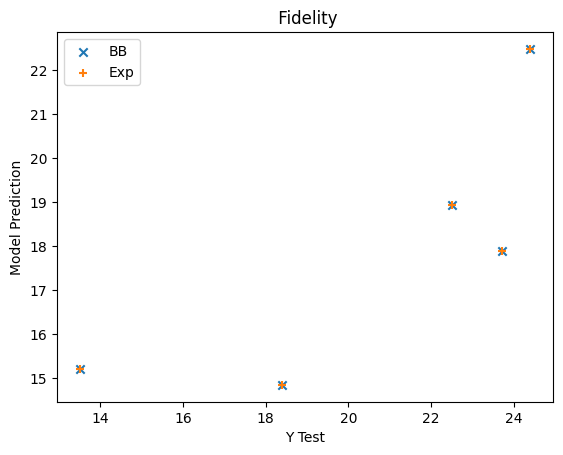

In [19]:
Reg_Stats.Fidelity()

In [20]:
Reg_Stats.Jaccard_Values()

Mean Jaccard Similarity:  1.0
Mean Jaccard Distance:    0.0


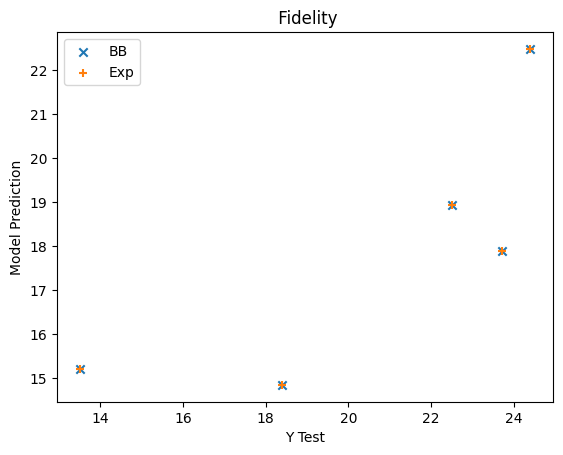

In [21]:
Reg_Stats.Reg_Fidelity_Graph()

top_features True
top_features (5, 12)


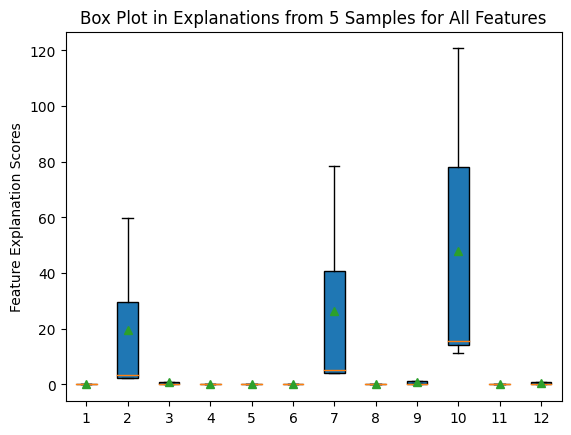

1 -      crime_rate
2 -      zoned_lots
3 -      industry
4 -      by_river
5 -      NOX
6 -      avg_rooms
7 -      pre_1940
8 -      emp_distance
9 -      rad_access
10 -     tax_rate
11 -     pupil_tea_rat
12 -     low_status


In [22]:
Reg_Stats.Box_Plot()


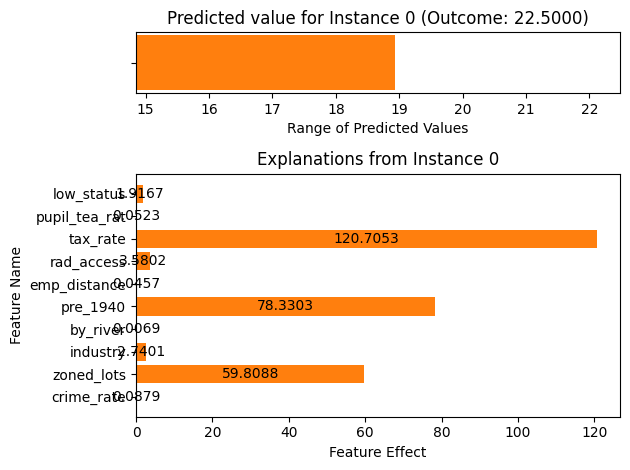

In [23]:
Reg_Stats.View_Explanation(instance = 0)

In [24]:
scores = URM_Exp.permutation_importance()
    
print(scores)

[6.18146322e-04 1.68758516e+00 2.53526344e-02 1.54845166e-07
 4.52690746e-09 3.77124352e-06 2.76848167e+00 3.16805951e-04
 3.46513264e-02 7.42716250e+00 3.63356252e-04 1.68251200e-02]


In [25]:
scores_k = URM_Exp.KL_imp()

print(scores_k)

[1.88029414 1.87943374 1.88023303 1.88030335 1.88030345 1.88030285
 1.87907877 1.88029695 1.8802196  1.79623414 1.88029645 1.88024736]


In [26]:
scores_v = URM_Exp.Var_imp()

print(scores_v)

[0.38205227 0.38718435 0.38241469 0.38199765 0.38199707 0.38200061
 0.38932027 0.3820356  0.3824944  1.32142928 0.38203854 0.38232967]


In [27]:
scores_d1 = URM_Exp.del_1_rel()

print(scores_d1)

[7.59235351e-09 0.00000000e+00 1.01904948e-03 0.00000000e+00
 2.45165302e-08 3.49066443e-08 3.48613678e-07 3.78096691e-06
 1.11161236e-05 1.16766023e+01 3.80086809e-02 2.84354698e-01]


In [28]:
scores_d2 = URM_Exp.del_2_rel()

print(scores_d2)

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[0.79628401 0.87790312 0.5753152  0.39017916 0.24087591 0.16124751
 2.72528202 1.0530856  0.199071   0.39017916 1.24419376 3.34638354]


In [29]:
lin_scores = URM_Exp.Lin_scores()

print(lin_scores)

[ 2.24043829e+07 -7.08343819e+07 -1.41107046e+06 -2.68471154e+07
 -3.55091657e+07 -4.74475182e+07  3.31288331e+07 -1.98391992e+08
  5.58183691e+07  1.96124874e+06 -1.38258829e+07  7.93010959e+07]


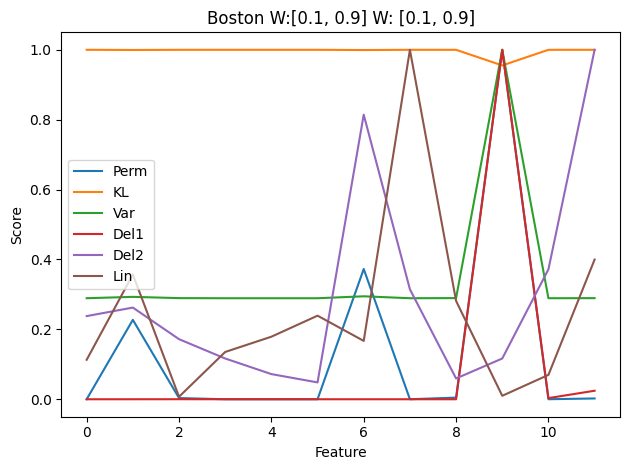

In [30]:
URM_Exp.plot_scores(Title, FUR_Weight)

In [31]:
print(URM_Exp.get_exp_L())


[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 9.38909481e-01  3.44164186e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 3.95368990e-02 -2.56245546e-02  9.98889491e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.0

In [32]:
acq_data.Create_BB_plot()

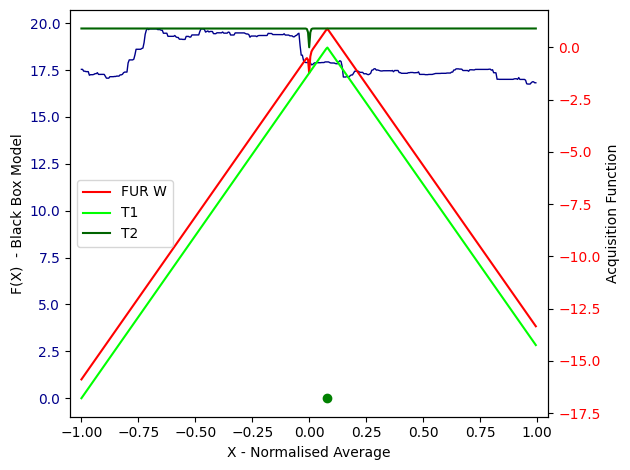

In [33]:
acq_data.plot_point(0)

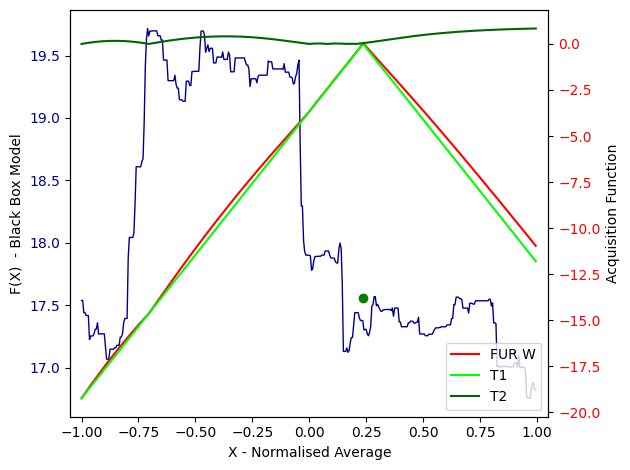

In [34]:
acq_data.plot_point(5)

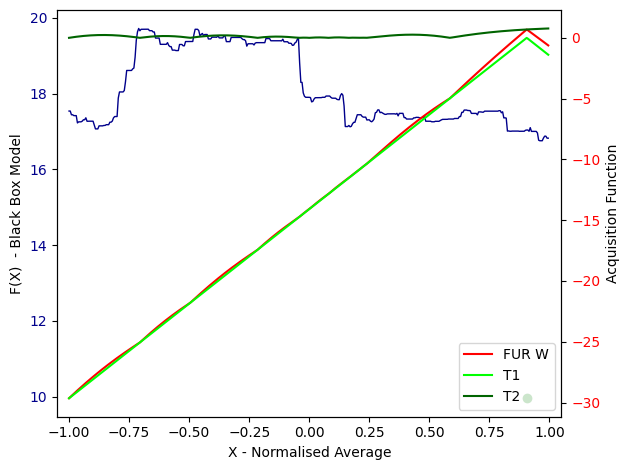

In [35]:
acq_data.plot_point(10)

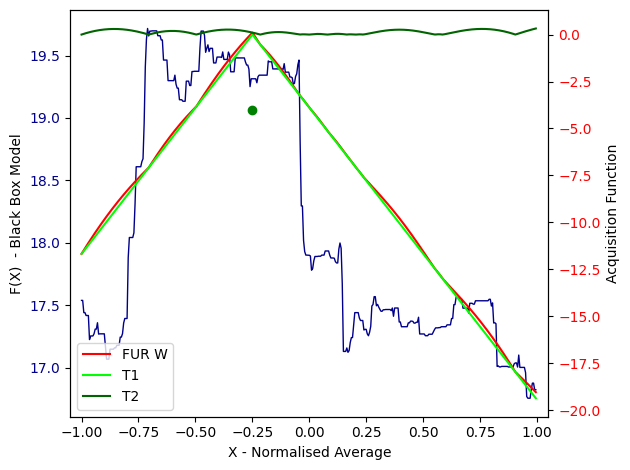

In [36]:
acq_data.plot_point(15)

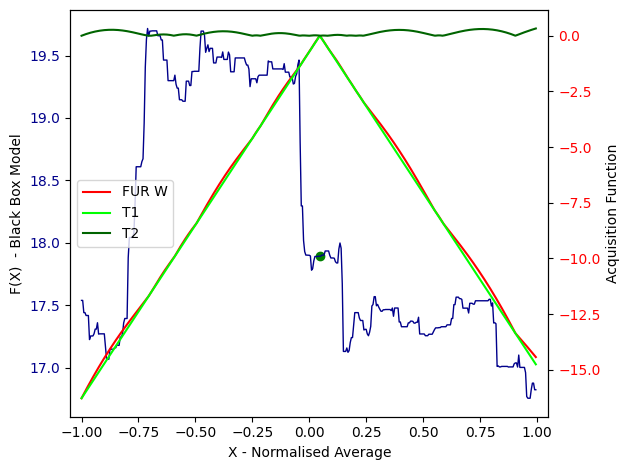

In [37]:
acq_data.plot_point(19)

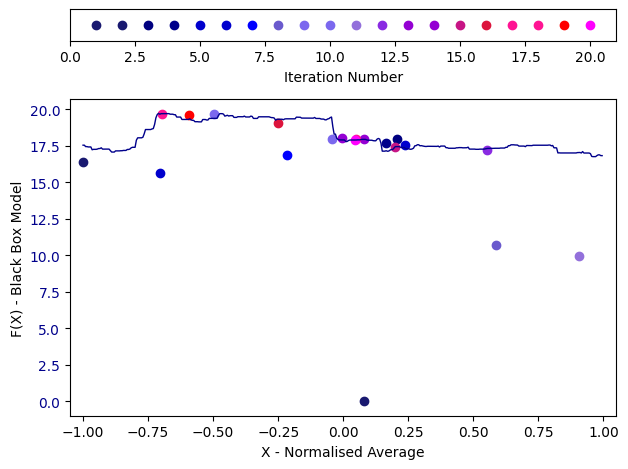

In [38]:
acq_data.plot_all()

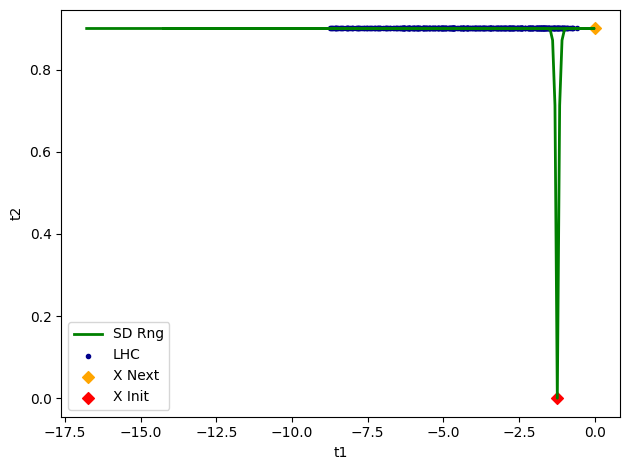

In [39]:
acq_data.plot_t1_t2(0)

In [40]:
#acq_data.plot_t1_t2(1)

In [41]:
#acq_data.plot_t1_t2(2)

In [42]:
#acq_data.plot_t1_t2(3)

In [43]:
#acq_data.plot_t1_t2(4)

In [44]:
#acq_data.plot_t1_t2(5)

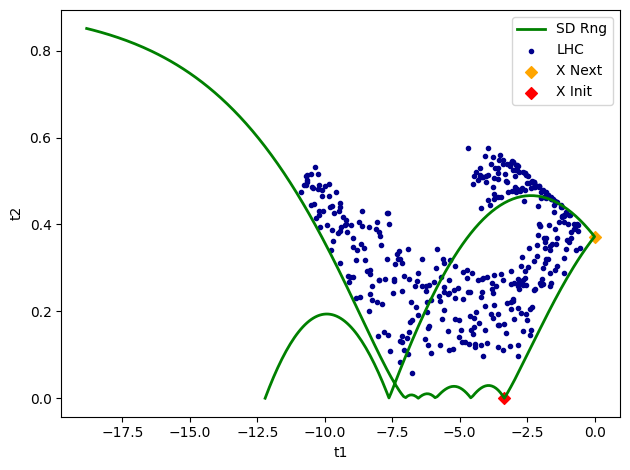

In [45]:
acq_data.plot_t1_t2(6)

In [46]:
#acq_data.plot_t1_t2(7)

In [47]:
#acq_data.plot_t1_t2(8)

In [48]:
#acq_data.plot_t1_t2(9)

In [49]:
#acq_data.plot_t1_t2(10)

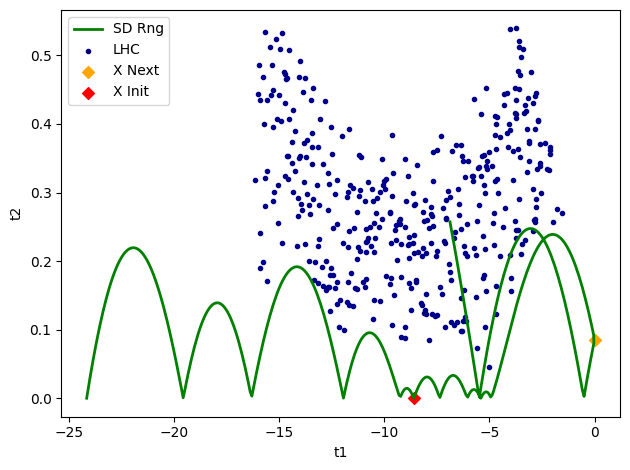

In [50]:
acq_data.plot_t1_t2(11)

In [51]:
#acq_data.plot_t1_t2(12)

In [52]:
#acq_data.plot_t1_t2(13)

In [53]:
#acq_data.plot_t1_t2(14)

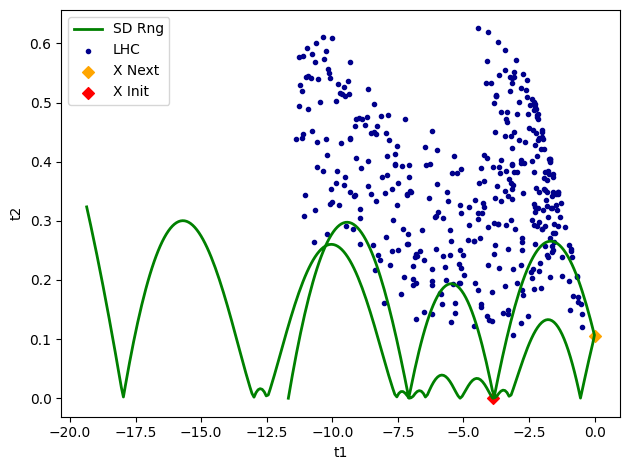

In [54]:
acq_data.plot_t1_t2(15)

In [55]:
#acq_data.plot_t1_t2(16)

In [56]:
#acq_data.plot_t1_t2(17)

In [57]:
#acq_data.plot_t1_t2(18)

In [58]:
#acq_data.plot_t1_t2(19)

Average, SD, and Max Differences:
y - BB(x):           3.3110000000000044  :  1.470429597090594  :  5.800000000000008
y - exp(x):          3.3110000123777636  :  1.4704296297230874  :  5.800000080819554
BB(x) - exp(x):      2.2356926265842957e-08  :  2.9717279683792447e-08  :  8.081954661065538e-08
Average exp(x) Uncertainty:  9.999999303478559e-06
R Score:   0.9999999999999998
Fidelity:  0.16151219572574457


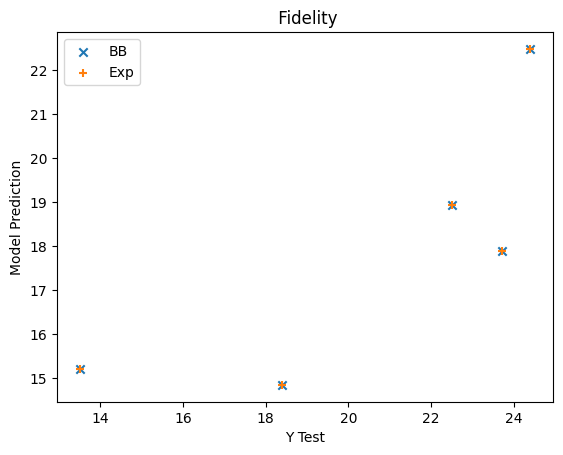

Fidelity:  0.16151219572574457


In [59]:
Reg_Stats.Fidelity()

print('Fidelity: ', Reg_Stats.fidelity)

In [60]:
Reg_Stats.Jaccard_Values(top_k=4)

print('Jaccard: ', Reg_Stats.jaccard_similarities)

Mean Jaccard Similarity:  1.0
Mean Jaccard Distance:    0.0
Jaccard:  1.0


In [61]:
Reg_Stats.add_Feature_Coeffs(Feature_Coeffs = Reg_Data.get_Feature_Coeffs())
        
print('Coeff Ratio: ', Reg_Stats.coeffs_ratio)

<class 'AttributeError'>: 'BB_Model' object has no attribute 'Feature_Coeffs'

In [62]:
delete_1_var = Reg_Stats.delete_one()

print('Delete 1 Variance: ', delete_1_var)

mean_variance [1.92921996e-01 0.00000000e+00 9.95581039e+00 0.00000000e+00
 9.82340430e-05 4.98971435e-01 1.57121042e+02 7.46708032e-02
 1.49428960e+01 3.13091377e+02 2.30265068e+01 1.83620613e+01]
Mean scores: [1.92921996e-01 0.00000000e+00 9.95581039e+00 0.00000000e+00
 9.82340430e-05 4.98971435e-01 1.57121042e+02 7.46708032e-02
 1.49428960e+01 3.13091377e+02 2.30265068e+01 1.83620613e+01]
sort_order [ 5  4  3  7 10  0 11  2  8  1  6  9]
sorted_scores [1.90381233e-05 1.09310643e-04 1.71750934e-04 1.59300575e-03
 1.82229534e-03 3.06107295e-03 6.78315539e-02 9.74878424e-02
 1.27955128e-01 2.42737312e+00 3.29712103e+00 5.97545486e+00]
sorted_variance [1.11446718e-02 2.19408586e-06 0.00000000e+00 1.66779406e-03
 5.14303713e-01 4.30896878e-03 4.10121968e-01 2.22365915e-01
 3.33753920e-01 0.00000000e+00 3.50934408e+00 6.99298677e+00]
Prediction Variance Feature Deletion: [1.92921996e-01 0.00000000e+00 9.95581039e+00 0.00000000e+00
 9.82340430e-05 4.98971435e-01 1.57121042e+02 7.46708032e-0

N_Points:  25


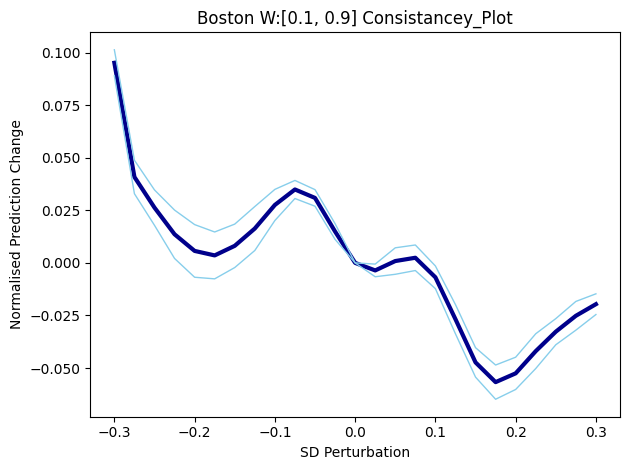

In [63]:
Reg_Stats.Consistancy(std_bound = consist_bound, plot=True, title = Title)

In [64]:
Reg_Stats.Compare_Models (model_b = Reg_Stats_2)

Score Diff Mean:  [3.22793424e-03 2.55911372e+00 1.02799978e-01 1.81118197e-04
 1.15272433e-04 2.00760591e-05 3.47570194e+00 1.67984426e-03
 1.34926963e-01 5.64878354e+00 1.92163240e-03 7.15279859e-02]
Score Diff SD:    [4.44647600e-03 2.97361172e+00 1.38215502e-01 3.61646309e-04
 2.30528038e-04 2.74243090e-05 3.87092825e+00 2.31201543e-03
 1.80546668e-01 5.73847465e+00 2.64546559e-03 9.67055265e-02]


Calibration MSE/MAE 0.7890067495708684 0.5836686932043952


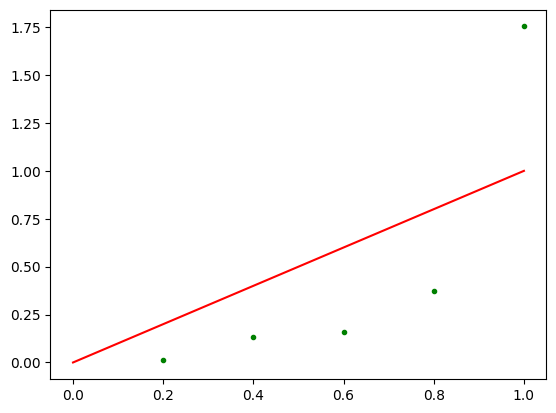

In [65]:
Reg_Stats.Regression_Calibration(plot=True, title=Title)

In [66]:
print(Reg_Stats.calibration_MAE)

0.5836686932043952


In [67]:
Reg_Stats.delete_one()

mean_variance [1.92921996e-01 0.00000000e+00 9.95581039e+00 0.00000000e+00
 9.82340430e-05 4.98971435e-01 1.57121042e+02 7.46708032e-02
 1.49428960e+01 3.13091377e+02 2.30265068e+01 1.83620613e+01]
Mean scores: [1.92921996e-01 0.00000000e+00 9.95581039e+00 0.00000000e+00
 9.82340430e-05 4.98971435e-01 1.57121042e+02 7.46708032e-02
 1.49428960e+01 3.13091377e+02 2.30265068e+01 1.83620613e+01]
sort_order [ 5  4  3  7 10  0 11  2  8  1  6  9]
sorted_scores [1.90381233e-05 1.09310643e-04 1.71750934e-04 1.59300575e-03
 1.82229534e-03 3.06107295e-03 6.78315539e-02 9.74878424e-02
 1.27955128e-01 2.42737312e+00 3.29712103e+00 5.97545486e+00]
sorted_variance [1.11446718e-02 2.19408586e-06 0.00000000e+00 1.66779406e-03
 5.14303713e-01 4.30896878e-03 4.10121968e-01 2.22365915e-01
 3.33753920e-01 0.00000000e+00 3.50934408e+00 6.99298677e+00]
Prediction Variance Feature Deletion: [1.92921996e-01 0.00000000e+00 9.95581039e+00 0.00000000e+00
 9.82340430e-05 4.98971435e-01 1.57121042e+02 7.46708032e-0

In [68]:
Reg_Stats.Results_Summary(Title)

Results_Summary: Boston W:[0.1, 0.9]
R Score:   0.9999999999999998
Fidelity:  0.16151219572574457
Consistancey Std/Y Pert:  0.3 : 0.03774047624032943
Delete One Incoherence:   0.4046086637874777
Mean Jaccard Similarity:  1.0
Mean Jaccard Distance:    0.0
Calibration MSE/MAE:  0.7890067495708684 : 0.5836686932043952
Score Diff Mean:  [3.22793424e-03 2.55911372e+00 1.02799978e-01 1.81118197e-04
 1.15272433e-04 2.00760591e-05 3.47570194e+00 1.67984426e-03
 1.34926963e-01 5.64878354e+00 1.92163240e-03 7.15279859e-02]
Score Diff SD:    [4.44647600e-03 2.97361172e+00 1.38215502e-01 3.61646309e-04
 2.30528038e-04 2.74243090e-05 3.87092825e+00 2.31201543e-03
 1.80546668e-01 5.73847465e+00 2.64546559e-03 9.67055265e-02]
